In [1]:
# !gdown 1sui9RXxVsPDa4s2kooQwRGhb8taZhcgD --output ../../data/nlp/news_summary.csv
# !gdown 1H3gdo7SLBiWE_GGD6_xcdAp2wJJFcd5L --output ../../data/nlp/news_summary_raw.csv
config = {'min_text_len':40,
          'max_text_len':60,
          'max_summary_len':30,
          'latent_dim' : 300,
          'embedding_dim' : 200}

In [2]:
#import libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('dark'))
plt.rcParams['figure.figsize'] = (10 , 10)
plt.rcParams['font.size'] = 20

In [3]:
!ls ./sample_data

ls: ./sample_data: No such file or directory


In [16]:

dir = '../../data/nlp/'

print(f'{dir}')

summary = pd.read_csv(f'{dir}news_summary.csv' , encoding = 'iso-8859-1')
raw = pd.read_csv(f'{dir}news_summary_raw.csv' , encoding = 'iso-8859-1')
raw = raw.rename(columns = {'headlines' : 'summary'})
summary = summary[['headlines' , 'text']].rename(columns = {'headlines' : 'summary'})
summary.shape , raw.shape

../../data/nlp/


((4514, 2), (98401, 2))

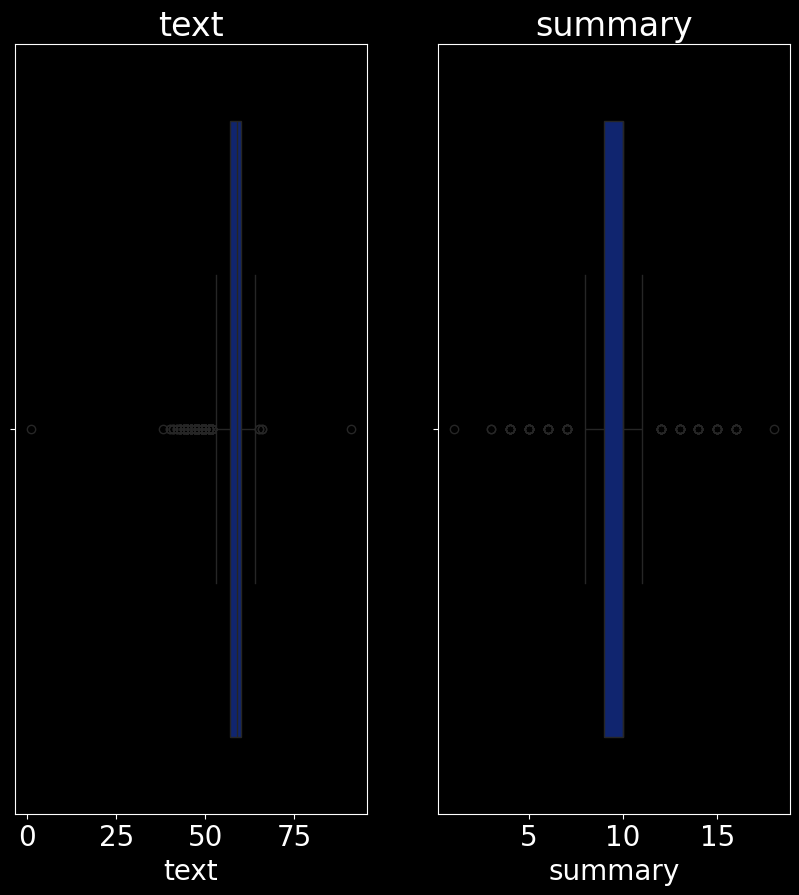

In [17]:
#distribution of words:
plt.subplot(1 , 2, 1)
sns.boxplot(x = raw.text.str.split().str.len())
plt.title('text')

plt.subplot(1 , 2, 2)
sns.boxplot(x = raw.summary.str.split().str.len())
plt.title('summary')
plt.show()

In [18]:
#filter text in range between 40 - 60 words:
print(f"Before filtering: {raw.shape}")
fraw = raw[((raw.text.str.split().str.len() > config['min_text_len']) & (raw.text.str.split().str.len() < config['max_text_len']))].reset_index(drop = True)
print(f"After filtering: {fraw.shape}")
fraw

Before filtering: (98401, 2)
After filtering: (55353, 2)


,summary,text
0,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
1,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...
2,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...
3,81-yr-old woman conducts physical training in ...,"Isha Ghosh, an 81-year-old member of Bharat Sc..."
4,"Karan Johar, Tabu turn showstoppers on opening...",Filmmaker Karan Johar and actress Tabu turned ...
...,...,...
55348,Pakistan starts building fence along Afghanist...,"Pakistan has started building a nearly 2,400-k..."
55349,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
55350,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
55351,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."


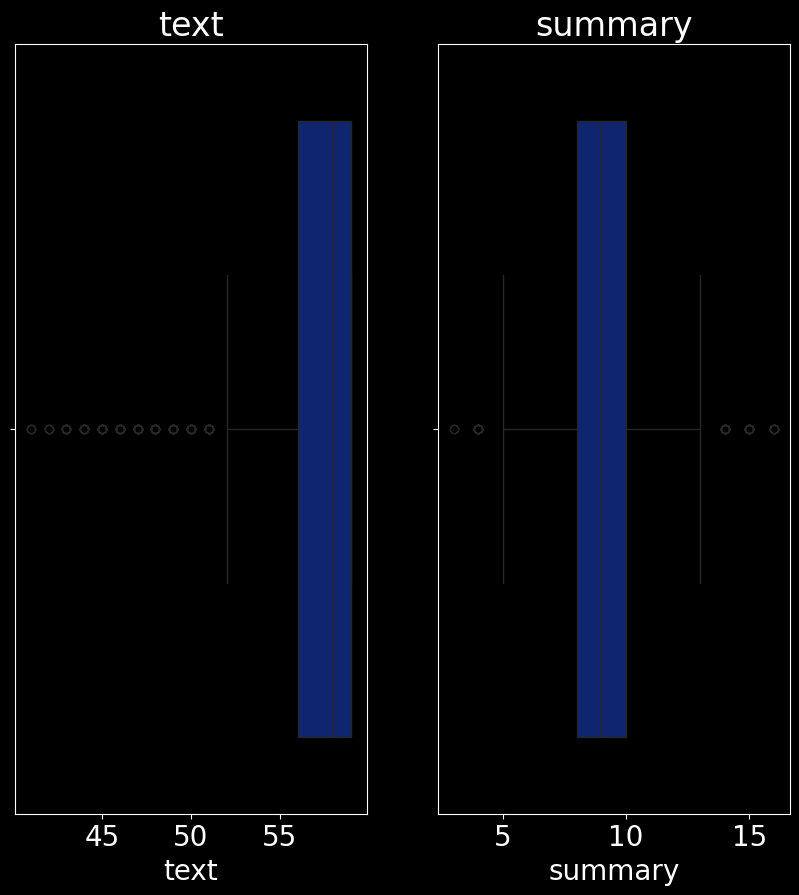

In [19]:
#distribution of words after filtering:
plt.subplot(1 , 2, 1)
sns.boxplot(x = fraw.text.str.split().str.len())
plt.title('text')

plt.subplot(1 , 2, 2)
sns.boxplot(x = fraw.summary.str.split().str.len())
plt.title('summary')
plt.show()

In [20]:
#peek at a sample:
i = 6
print(f"Text: {fraw.text[i]} \n Summary: {fraw.summary[i]} \n Text Length: {len(fraw.text[i].split())} \n Summary Length: {len(fraw.summary[i].split())}")


Text: Claiming there is a dearth of ideas among opposition parties, Prime Minister Narendra Modi on Wednesday said, "The opposition talks only about Modi the whole day, I suspect they even dream about me." PM Modi, who was addressing the New India Youth Conclave inÃ¢ÂÂ Surat, added that the opposition parties have only one agenda which is "Modi".  
 Summary: I think the opposition even dreams about me: PM Modi 
 Text Length: 57 
 Summary Length: 10


In [21]:
def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

softmax([20 , 30]) , softmax([0.2 , 0.3])

(array([4.53978687e-05, 9.99954602e-01]), array([0.47502081, 0.52497919]))

In [22]:
tf.nn.softmax(tf.constant([20 , 30] , dtype= tf.float32))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.539787e-05, 9.999546e-01], dtype=float32)>

In [23]:
# text pre processing:
import re

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(sentence):

    sentence = re.sub("(\\t)", " ", str(sentence)).lower()
    sentence = re.sub("(\\r)", " ", str(sentence)).lower()
    sentence = re.sub("(\\n)", " ", str(sentence)).lower()

    # Remove - if it occurs more than one time consecutively
    sentence = re.sub("(--+)", " ", str(sentence)).lower()

    # Remove . if it occurs more than one time consecutively
    sentence = re.sub("(\.\.+)", " ", str(sentence)).lower()

    # Remove the characters - <>()|&©ø"',;?~*!
    sentence = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(sentence)).lower()

    # Remove \x9* in text
    sentence = re.sub(r"(\\x9\d)", " ", str(sentence)).lower()

    # Replace CM# and CHG# to CM_NUM
    sentence = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(sentence)).lower()

    # Remove punctuations at the end of a word
    sentence = re.sub("(\.\s+)", " ", str(sentence)).lower()
    sentence = re.sub("(\-\s+)", " ", str(sentence)).lower()
    sentence = re.sub("(\:\s+)", " ", str(sentence)).lower()

    # Remove multiple spaces
    sentence = re.sub("(\s+)", " ", str(sentence)).lower()

    return sentence

In [24]:
fraw['cleaned_text'] = fraw['text'].apply(text_strip)
fraw['cleaned_summary'] = fraw['summary'].apply(lambda x : '_START_ ' + text_strip(x) + ' _END_')
fraw['cleaned_summary'] = fraw['cleaned_summary'].apply(lambda x : 'sostok' + x + 'eostok')
fraw.head()

,summary,text,cleaned_text,cleaned_summary
0,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,pakistani singer rahat fateh ali khan has deni...,sostok_START_ rahat fateh ali khan denies gett...
1,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...,india recorded their lowest odi total in new z...,sostok_START_ india get all out for 92 their l...
2,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...,andhra pradesh cm n chandrababu naidu has said...,sostok_START_ called pm modi sir 10 times to s...
3,81-yr-old woman conducts physical training in ...,"Isha Ghosh, an 81-year-old member of Bharat Sc...",isha ghosh an 81-year-old member of bharat sco...,sostok_START_ 81-yr-old woman conducts physica...
4,"Karan Johar, Tabu turn showstoppers on opening...",Filmmaker Karan Johar and actress Tabu turned ...,filmmaker karan johar and actress tabu turned ...,sostok_START_ karan johar tabu turn showstoppe...


In [25]:
#filter according to word limit
print('pre filter shape:', fraw.shape)
pdf = fraw[((fraw['text'].str.split().str.len() <= config['max_text_len']) & (fraw['summary'].str.split().str.len() <= (config['max_summary_len'] + 4)))].copy()

pdf = pdf.reset_index(drop= True)
pdf = pdf[['cleaned_text' , 'cleaned_summary']].rename(columns= {'cleaned_text' : 'text' , 'cleaned_summary' : 'summary'})
print(f"Post filtering shape: {pdf.shape}")
pdf

pre filter shape: (55353, 4)
Post filtering shape: (55353, 2)


,text,summary
0,pakistani singer rahat fateh ali khan has deni...,sostok_START_ rahat fateh ali khan denies gett...
1,india recorded their lowest odi total in new z...,sostok_START_ india get all out for 92 their l...
2,andhra pradesh cm n chandrababu naidu has said...,sostok_START_ called pm modi sir 10 times to s...
3,isha ghosh an 81-year-old member of bharat sco...,sostok_START_ 81-yr-old woman conducts physica...
4,filmmaker karan johar and actress tabu turned ...,sostok_START_ karan johar tabu turn showstoppe...
...,...,...
55348,pakistan has started building a nearly 2 400-k...,sostok_START_ pakistan starts building fence a...
55349,a crpf jawan was on tuesday axed to death with...,sostok_START_ crpf jawan axed to death by maoi...
55350,uff yeh the first song from the sonakshi sinh...,sostok_START_ first song from sonakshi sinha s...
55351,according to reports a new version of the 1999...,sostok_START_ the matrix film to get a reboot...


In [26]:
from sklearn.model_selection import train_test_split

xtrain , xtest , ytrain , ytest = train_test_split(np.array(pdf['text']) , np.array(pdf['summary']) , test_size= 0.1 , random_state= True , shuffle = True)

xtrain.shape , xtest.shape , ytrain.shape , ytest.shape

((49817,), (5536,), (49817,), (5536,))

In [27]:
#tokenize a set of rare words from test set:
from tensorflow.keras.preprocessing.text import Tokenizer

def get_rare_words(text_col):

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(list(text_col))

    thres = 5

    count = 0
    tcount = 0

    for key , value in tokenizer.word_counts.items():
        tcount += 1

        if value < thres:
            count+= 1
    print(f"% of rare words in vocabulary: {np.round((count / tcount) * 100 , 2)}")

    return count , tcount

get_rare_words(xtrain)

% of rare words in vocabulary: 64.0


(40499, 63284)

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#tokenize the train set without the rare words:
xtraincount , xtraintcount = get_rare_words(xtrain)
xtokenizer = Tokenizer(num_words = xtraintcount - xtraincount)

#learn the tokens:
xtokenizer.fit_on_texts(list(xtrain))

#tonekize the train and test set:
xtrainseq = xtokenizer.texts_to_sequences(xtrain)
xtestseq = xtokenizer.texts_to_sequences(xtest)

#pad the sequences:

xtrain = pad_sequences(xtrainseq , maxlen = config['max_text_len'] , padding = 'post')
xtest = pad_sequences(xtestseq , maxlen = config['max_text_len'] , padding = 'post')

xvocab = xtokenizer.num_words + 1
print(f"size of vocabulary in xtrain and xtest: {xvocab}")
print(xtokenizer.num_words)


% of rare words in vocabulary: 64.0
size of vocabulary in xtrain and xtest: 22786
22785


In [29]:
#tokenize the y variable without rare words:
ycount , ytcount = get_rare_words(ytrain)
ytokenizer = Tokenizer(num_words= ytcount - ycount)
ytokenizer.fit_on_texts(ytrain)

#tokenize the text:
ytrainseq = ytokenizer.texts_to_sequences(ytrain)
ytestseq = ytokenizer.texts_to_sequences(ytest)

ytrain = pad_sequences(ytrainseq , maxlen = config['max_summary_len'] , padding = 'post')
ytest = pad_sequences(ytestseq , maxlen = config['max_summary_len'] , padding = 'post')

yvocab = ytokenizer.num_words + 1

print(f'size of y vocabulary: {ytokenizer.num_words + 1}')

% of rare words in vocabulary: 66.07
size of y vocabulary: 9489


In [30]:
config

{'min_text_len': 40,
 'max_text_len': 60,
 'max_summary_len': 30,
 'latent_dim': 300,
 'embedding_dim': 200}

In [40]:
#encoder decoder architecture:
import tensorflow as tf
from tensorflow.keras.layers import Input , Embedding , LSTM , TimeDistributed , Dense
from tensorflow.keras.models import Sequential , Model
latent_dim = config['latent_dim']
embedding_dim = config['embedding_dim']
max_text_len = config['max_text_len']
max_summary_len = config['max_summary_len']

# Encoder
encoder_inputs = Input(shape=(max_text_len, ) , name = 'encoder_input')

# Embedding layer
enc_emb = Embedding(xvocab, embedding_dim,
                    trainable=True , name = 'encoder_embedding')(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4 , name = 'elstm1')
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4 , name = 'elstm2')
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4 , name = 'elstm3')
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(max_summary_len - 1,) , name = 'dinput')

# Embedding layer
dec_emb_layer = Embedding(yvocab, embedding_dim, trainable=True , name = 'decoder_input')
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2 , name = 'dlstm')
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(yvocab, activation='softmax' , name = 'time_dense'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs , name = 'auto-encoder')

model.summary()

Model: "auto-encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 60, 200)   │  4,557,200 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ elstm1 (LSTM)       │ [(None, 60, 300), │    601,200 │ encoder_embeddin… │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dinput (InputLayer) │ (None, 29)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ elstm2 (LSTM)       │ [(None, 60, 300), │    721,200 │ elstm1[0][0]      │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 29, 200)   │  1,897,800 │ dinput[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ elstm3 (LSTM)       │ [(None, 60, 300), │    721,200 │ elstm2[0][0]      │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dlstm (LSTM)        │ [(None, 29, 300), │    601,200 │ decoder_input[0]… │
│                     │ (None, 300),      │            │ elstm3[0][1],     │
│                     │ (None, 300)]      │            │ elstm3[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 29, 9489)  │  2,856,189 │ dlstm[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,955,989 (45.61 MB)

 Trainable params: 11,955,989 (45.61 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
#compile and train the model:
model.compile(optimizer = 'Adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])


save_model = tf.keras.callbacks.ModelCheckpoint(filepath = './models/lstm.weights.h5' , save_weights_only = True , save_best_only = True , verbose = 1)
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss' , mode = 'min' , verbose = 1 , patience = 10)

In [42]:
print("xtrain.shape:", xtrain.shape)
print("xtest.shape:", xtest.shape)
print("ytrain.shape:", ytrain.shape)
print("ytest.shape:", ytest.shape)
print("ytrain[:, :-1].shape:", ytrain[:, :-1].shape)
print("ytrain[:, 1:].shape (targets):", ytrain[:, 1:].shape)

# See what the model actually expects:
print("model.input shapes:", [i.shape for i in model.inputs])

# history = model.fit(
#     [xtrain, ytrain[:, :-1]],
#     ytrain[: , 1:],
#     epochs=500,
#     callbacks=[es, save_model],
#     batch_size=1024,
#     validation_data=([xtest, ytest[:, :-1]],
#                      ytest[:, 1:]),
#     )

xtrain.shape: (49817, 60)
xtest.shape: (5536, 60)
ytrain.shape: (49817, 30)
ytest.shape: (5536, 30)
ytrain[:, :-1].shape: (49817, 29)
ytrain[:, 1:].shape (targets): (49817, 29)
model.input shapes: [(None, 60), (None, 29)]
Epoch 1/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5415 - loss: 5.8032
Epoch 1: val_loss improved from inf to 2.67895, saving model to ./models/lstm.weights.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 181s 4s/step - accuracy: 0.5424 - loss: 5.7679 - val_accuracy: 0.6245 - val_loss: 2.6789
Epoch 2/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6418 - loss: 2.6613
Epoch 2: val_loss improved from 2.67895 to 2.49640, saving model to ./models/lstm.weights.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.6422 - loss: 2.6603 - val_accuracy: 0.6894 - val_loss: 2.4964
Epoch 3/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6853 - loss: 2.5182
Epoch 3: val_loss improved from 2.49640 to 2.43058, saving model to ./models/lstm.weights.h5
49/49 ━━━━━━━━━━━━━

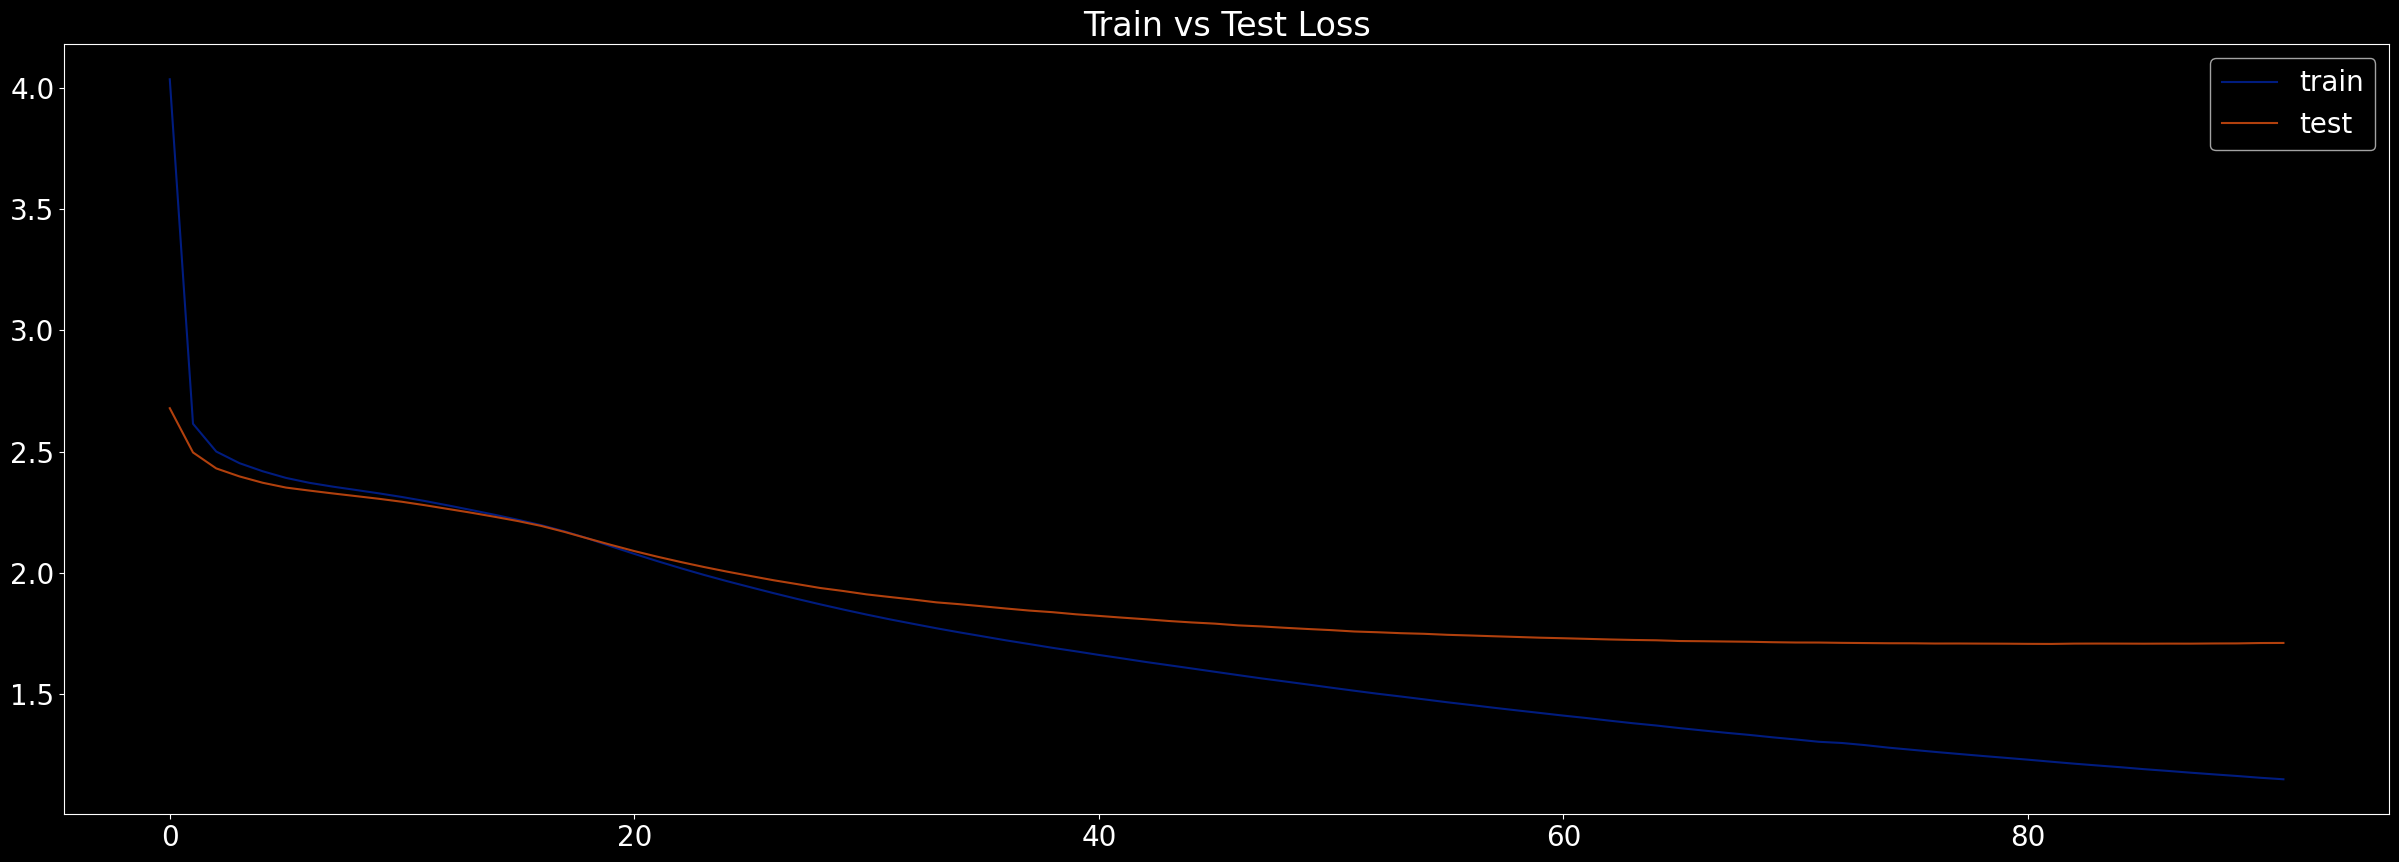

In [43]:
#plot training and validation loss:

plt.figure(figsize = (30 , 10))
plt.plot(history.history['loss'] , label = 'train')
plt.plot(history.history['val_loss'] , label = 'test')
plt.title('Train vs Test Loss')
plt.legend()
plt.show()

In [44]:
#inference model:

# 1. get output and states of encoder:

iencoder = Model(inputs = [encoder_inputs] , outputs = [encoder_outputs , state_h , state_c])

# 2. setup decoder:

decoder_h_state = keras.layers.Input(shape = (latent_dim , ) , name = 'h_state')
decoder_c_state = keras.layers.Input(shape = (latent_dim , ) , name = 'c_state')
decoder_inputsi = keras.layers.Input(shape = (1 , ))

# 3. get embedding of decoder:

dec_embi = dec_emb_layer(decoder_inputsi)

# 4. get output and states of decoder:

(decoder_outputsi , state_hi , state_ci) = decoder_lstm(dec_embi , initial_state = [decoder_h_state , decoder_c_state])


# 5. pass the outputs through a timedist layer to get word classifications:

decoder_outputsi = decoder_dense(decoder_outputsi)


# 6. create final model:

idecoder = keras.models.Model(inputs = [decoder_inputsi, decoder_h_state , decoder_c_state] , outputs = [decoder_outputsi , state_hi , state_ci] , name = 'inference_decoder')
idecoder.summary()

Model: "inference_decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 1, 200)    │  1,897,800 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h_state             │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c_state             │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dlstm (LSTM)        │ [(None, 1, 300),  │    601,200 │ decoder_input[1]… │
│                     │ (None, 300),      │            │ h_state[0][0],    │
│                     │ (None, 300)]      │            │ c_state[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 1, 9489)   │  2,856,189 │ dlstm[1][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,355,189 (20.43 MB)

 Trainable params: 5,355,189 (20.43 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# text generation:
# 1. convert sample to appropiate format

xseq = ['rnn be high high, re rnn high high high.']
xtok = xtokenizer.texts_to_sequences(xseq)
xpad = pad_sequences(xtok , maxlen= max_text_len , padding = 'post')
i = np.random.randint(0 , xtrain.shape[0])
text = xtrain[i]
print('text: ' , seq2text(text))

# 2. pass the tokenized sentence to encoder
(eout , hstate , cstate) = iencoder.predict(text.reshape(1 , -1))

# 3. generate the summary of the input seq

summary = ''
tseq = np.zeros((1,1))
tseq[0,0] = ytokenizer.word_index['sostok']

while True:
    logits , dhstate , dcstate = idecoder.predict([tseq , hstate , cstate] , verbose = 0)

    #sample token from output:

    itoken = np.argmax(logits)
    token = ytokenizer.index_word[itoken]
    summary += token

    if token == 'eostok' or len(summary.split()) >= max_summary_len - 1:
        summary += '.'
        break
    summary += ' '

    tseq[0 , 0] = itoken

    (hstate , cstate) = (dhstate , dcstate)

print('summary: ', summary)

text:  retired us navy admiral bruce and eight other current and former officers have been arrested for taking bribes in the form of lavish gifts prostitutes and luxury hotel stays in exchange for classified information the officers provided the information to a malaysian defence contractor which helped it gain a competitive advantage in bidding for ship contracts 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
summary:  start us state arrested for running in us over sex scandal end eostok.


In [46]:
def seq2text(input_seq):
    res = ''
    for i in input_seq:
        if i != 0:
            res += xtokenizer.index_word[i] + ' '

    return res


def seq2summary(input_seq):
    res = ''

    for i in input_seq:
        if i != 0 and i != ytokenizer.word_index['sostok'] and i != ytokenizer.word_index['eostok']:
            res += ytokenizer.index_word[i] + ' '

    return res



In [330]:
import spacy

from spacy import displacy

import en_core_web_sm , nlp 
en_core_web_sm.load()

text = input()

displacy.render(nlp(text), jupyter=True, style='ent')

TypeError: 'module' object is not callable